In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l1, l2
from keras.activations import sigmoid
from keras_tuner.tuners import RandomSearch, Hyperband
from keras_tuner import HyperModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

2023-08-31 20:13:23.433276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv("./data_original/2023빅콘테스트_어드밴스드리그_예술의전당.csv", encoding='utf-8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920868 entries, 0 to 1920867
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   age                float64
 1   gender             object 
 2   membership_type_1  object 
 3   membership_type_2  object 
 4   membership_type_3  object 
 5   membership_type_4  object 
 6   membership_type_5  object 
 7   membership_type_6  float64
 8   tran_date          int64  
 9   tran_time          int64  
 10  play_date          int64  
 11  play_st_time       int64  
 12  seat               object 
 13  price              int64  
 14  ticket_cancel      int64  
 15  discount_type      object 
 16  performance_code   int64  
 17  pre_open_date      float64
 18  open_date          float64
 19  genre              object 
 20  place              object 
 21  running_time       int64  
 22  intermission       int64  
 23  member_yn          object 
dtypes: float64(4), int64(9), object(11)
memory usage: 

In [4]:
df.isnull().sum()

age                  1300183
gender               1299714
membership_type_1    1299714
membership_type_2    1433215
membership_type_3    1749009
membership_type_4    1890675
membership_type_5    1919586
membership_type_6    1920868
tran_date                  0
tran_time                  0
play_date                  0
play_st_time               0
seat                       0
price                      0
ticket_cancel              0
discount_type              0
performance_code           0
pre_open_date         864385
open_date                340
genre                  25842
place                      0
running_time               0
intermission               0
member_yn                  0
dtype: int64

In [5]:
from holidays import KR

# FunctionTransformer를 사용하여 변환 함수 정의
def transform_play_date(df):
    # 월과 일 컬럼 추가
    df = pd.DataFrame(df)
    df_date = df['play_date'].astype(str)
    df_date = pd.to_datetime(df_date)
    df['month'] = df_date.dt.month
    df['day'] = df_date.dt.day

    kr_holidays  = KR()

    df['is_holyday'] = df_date.apply(lambda x: 1 if x in kr_holidays else 0).astype(object)

    return df

date_tranformer = FunctionTransformer(transform_play_date)

dd = date_tranformer.fit_transform(df['play_date'])

dd[dd['is_holyday'] == True]
# dd
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920868 entries, 0 to 1920867
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   play_date   int64 
 1   month       int64 
 2   day         int64 
 3   is_holyday  object
dtypes: int64(3), object(1)
memory usage: 58.6+ MB


In [6]:
import re

pattern = r'(\d+)%'
text = '22년 하반기 패키지 추가구매(1인2매)20%'
re.findall(pattern, text)

def extract_to_discount_rate(x):
    pattern = r'(\d+)%'
    match = re.search(pattern, x)
    if match:
        return match.group(1)
    else:
        return 0

def transform_discount_type(x):
    df = pd.DataFrame(x)
    df['discount_rate'] = df['discount_type'].apply(extract_to_discount_rate).astype('float64')

    return df

discount_type_transform = FunctionTransformer(transform_discount_type)

dd = discount_type_transform.fit_transform(df['discount_type'])
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920868 entries, 0 to 1920867
Data columns (total 2 columns):
 #   Column         Dtype  
---  ------         -----  
 0   discount_type  object 
 1   discount_rate  float64
dtypes: float64(1), object(1)
memory usage: 29.3+ MB


In [32]:
def transform_floor(df):
    df = pd.DataFrame(df)
    df['floor'] = df['seat'].str.extract(r'(\d+)층')
    df['floor'].fillna(0, inplace = True)
    df['floor'] = df['floor'].astype('int32')
    df['block'] = df['seat'].str.extract(r'(\w)블록')
    df['block'].fillna(0, inplace = True)
    df['block'] = df['block'].apply(lambda x: ord(x) - 64 if x != 0 else 0)
    df['column'] = df['seat'].str.extract(r'(\d+)열')
    df['column'].fillna(0, inplace = True)
    return df

def transform_performance(df):
    df = pd.DataFrame(df)
    df['perf'] = df['place'] + df['play_date'].astype(str) + df['play_st_time'].astype(str)
    df['perf_floor'] = df['perf'] + df['floor'].astype(str)
    df['perf_floor_block'] = df['perf_floor'] + df['block'].astype(str)
    df['perf_floor_column'] = df['perf_floor_block'] + df['column'].astype(str)
    return df

df_transformed = transform_floor(df)
df_transformed = transform_performance(df_transformed)

df_transformed

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_type_6,tran_date,tran_time,...,intermission,member_yn,floor,block,column,perf,perf_floor,perf_floor_block,perf_floor_column,price_orig
0,50.0,F,골드,무료,그린,NaN,NaN,NaN,20220114,1512,...,15,Y,3,0,0,콘서트홀202202042000,콘서트홀2022020420003,콘서트홀20220204200030,콘서트홀202202042000300,10000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211003,1550,...,15,N,1,0,7,리사이틀홀202110092000,리사이틀홀2021100920001,리사이틀홀20211009200010,리사이틀홀202110092000107,20000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220917,1520,...,15,N,1,3,16,IBK챔버홀202211052000,IBK챔버홀2022110520001,IBK챔버홀20221105200013,IBK챔버홀2022110520001316,30000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20190630,1132,...,15,N,1,0,2,리사이틀홀201907312000,리사이틀홀2019073120001,리사이틀홀20190731200010,리사이틀홀201907312000102,20000
4,50.0,M,무료,NaN,NaN,NaN,NaN,NaN,20220206,1615,...,0,Y,1,2,12,콘서트홀202203021930,콘서트홀2022030219301,콘서트홀20220302193012,콘서트홀2022030219301212,180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20190614,920,...,15,N,1,1,14,IBK챔버홀201907061400,IBK챔버홀2019070614001,IBK챔버홀20190706140011,IBK챔버홀2019070614001114,5000
1920864,20.0,F,무료,싹틔우미,NaN,NaN,NaN,NaN,20221224,1223,...,0,Y,3,2,5,콘서트홀202304081700,콘서트홀2023040817003,콘서트홀20230408170032,콘서트홀202304081700325,30000
1920865,50.0,F,블루,무료,그린,NaN,NaN,NaN,20210614,129,...,15,Y,1,0,7,리사이틀홀202106192000,리사이틀홀2021061920001,리사이틀홀20210619200010,리사이틀홀202106192000107,30000
1920866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211123,1617,...,15,N,1,2,9,IBK챔버홀202111272000,IBK챔버홀2021112720001,IBK챔버홀20211127200012,IBK챔버홀202111272000129,30000


In [8]:
df_transformed[df_transformed['perf_floor_block'] == '콘서트홀20220302193012']['price']

4          180000
14386      180000
15757      171000
18094      171000
20096      171000
            ...  
1903106    162000
1912076    162000
1914534    162000
1915285    171000
1919117    171000
Name: price, Length: 311, dtype: int64

In [9]:
def transform_price_original(df):
    df = pd.DataFrame(df)
    max_values = df.groupby('perf_floor_block')['price'].max().to_dict()
    df['price_orig'] = df['perf_floor_block'].map(max_values)
    return df

df_transformed = transform_price_original(df_transformed)
# max_values = df_transformed.groupby('perf_floor_block')['price'].max().to_dict()
# df_transformed['max_value'] = df_transformed['perf_floor_block'].map(max_values)
# df_transformed[df_transformed['perf_floor_block'] == '콘서트홀20220302193012']['max_value']
df_transformed['price_orig'].min()


0

In [10]:
def transform_price_original_filter(df):
    df = pd.DataFrame(df)
    return df[df['price_orig']> 0]

df_transformed = transform_price_original_filter(df_transformed)
df_transformed['price_orig'].reset_index(drop=True).min()

1000

In [11]:
df_transformed[df_transformed['perf_floor_block'] == 'IBK챔버홀20181117200011']['price']

Series([], Name: price, dtype: int64)

In [38]:
def transform_x_y(df):
    df = pd.DataFrame(df)

    y = df[['price_orig']].values.flatten()
    x =  df.drop(['price', 'price_orig'], axis = 1)
    return x, y
    

train_x_y_pipeline = Pipeline([
    ('floor_transform', FunctionTransformer(transform_floor)),
    ('floor_performance', FunctionTransformer(transform_performance)),
    ('price_original', FunctionTransformer(transform_price_original)),
    ('price_original_filter', FunctionTransformer(transform_price_original_filter)),
    ('date_transform', FunctionTransformer(transform_play_date)),
    ('discount_transform', FunctionTransformer(transform_discount_type, validate=False)),
    ('x_y', FunctionTransformer(transform_x_y)),
])

X, y = train_x_y_pipeline.fit_transform(df)
X.shape, y.shape

((1529615, 34), (1529615,))

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1529615 entries, 0 to 1920867
Data columns (total 34 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   age                620685 non-null   float64
 1   gender             621154 non-null   object 
 2   membership_type_1  621154 non-null   object 
 3   membership_type_2  487653 non-null   object 
 4   membership_type_3  171859 non-null   object 
 5   membership_type_4  30193 non-null    object 
 6   membership_type_5  1282 non-null     object 
 7   membership_type_6  0 non-null        float64
 8   tran_date          1529615 non-null  int64  
 9   tran_time          1529615 non-null  int64  
 10  play_date          1529615 non-null  int64  
 11  play_st_time       1529615 non-null  int64  
 12  seat               1529615 non-null  object 
 13  ticket_cancel      1529615 non-null  int64  
 14  discount_type      1529615 non-null  object 
 15  performance_code   1529615 non-n

In [40]:
np.unique(X['floor'])

array([0, 1, 2, 3], dtype=int32)

In [41]:
categorical_columns = ['membership_type_1', 'membership_type_2',
       'membership_type_3', 'membership_type_4', 'membership_type_5',
       'is_holyday',
       'floor',
       'block']
continious_columns = ['running_time', 'intermission', 'play_st_time']
numeric_columns = [
    'performance_code', 'month', 'day', 'discount_rate'
]

selected_columns = categorical_columns + numeric_columns
column_transformer_pipeline = ColumnTransformer([
    ("onehot", OneHotEncoder(), categorical_columns),
    ("scaled", StandardScaler(), numeric_columns),
    ("minmax", MinMaxScaler(), continious_columns),
], remainder = "drop")

x_scaled_pipeline = Pipeline([
    ('column_transformer', column_transformer_pipeline)
])

X_scaled = x_scaled_pipeline.fit_transform(X)
X_scaled.shape

(1529615, 45)

In [42]:
# 예측기에 쓸 파이프라인
prediction_x_preprocessor = Pipeline([
    ('floor_transform', FunctionTransformer(transform_floor)),
    ('date_transform', FunctionTransformer(transform_play_date)),
    ('discount_transform', FunctionTransformer(transform_discount_type, validate=False)),
    ('column_transformer', column_transformer_pipeline)
])

prediction_x_preprocessor.fit_transform(df)

array([[1.        , 0.        , 0.        , ..., 0.34285714, 0.5       ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.25714286, 0.5       ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.22857143, 0.5       ,
        1.        ],
       ...,
       [0.        , 0.        , 1.        , ..., 0.28571429, 0.5       ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.25714286, 0.5       ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.28571429, 0.5       ,
        1.        ]])

In [43]:
df_scaled = pd.DataFrame(X_scaled)
df_scaled

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-1.297124,-1.374092,-1.302504,-0.487966,0.342857,0.5,1.000000
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.366851,1.034163,-0.744233,-0.487966,0.257143,0.5,1.000000
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.955774,1.335195,-1.190850,-0.487966,0.228571,0.5,1.000000
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.541459,0.131067,1.712159,-0.487966,0.257143,0.5,1.000000
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.620459,-1.073060,-1.525812,-0.487966,0.257143,0.0,0.922222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529610,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.201950,0.131067,-1.079196,-0.487966,0.285714,0.5,0.333333
1529611,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.284614,-0.772029,-0.855887,1.742323,0.342857,0.0,0.666667
1529612,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-0.803556,-0.169965,0.372309,0.998893,0.285714,0.5,1.000000
1529613,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.542951,1.335195,1.265542,-0.487966,0.257143,0.5,1.000000


In [44]:
X_data, X_test, y_data, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size = 0.2, random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((978953, 45), (244739, 45), (978953,), (244739,))

In [45]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
    
        model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', input_shape=self.input_shape))
        model.add(
            Dense(
                units=hp.Int("units", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(Dense(1)) # 출력 뉴런 1개 (연비 예측)

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5] )

        model.compile(
            optimizer=Adam(learning_rate = hp_learning_rate),
            loss='mse',
            metrics=['mae', 'mse'])

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32,]),
            **kwargs,
        )


In [46]:
from keras.callbacks import EarlyStopping

tuner = Hyperband(
    MyHyperModel(input_shape=X_train.shape[1:]),
    objective='val_mse',
    max_epochs=10,
    factor = 3, 
    directory='tuner_results',
    project_name='regression_tuning_05'
)

In [47]:
early_stopping = EarlyStopping(monitor="val_mse", patience=20, restore_best_weights=True)

In [48]:
tuner.search(X_train,
             y_train,
             validation_data = (X_valid, y_valid),
             epochs=10,
             callbacks=[early_stopping],
             verbose=1
             )

tuner.results_summary()

Trial 30 Complete [00h 18m 27s]
val_mse: 243804688.0

Best val_mse So Far: 243804688.0
Total elapsed time: 03h 36m 47s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in tuner_results/regression_tuning_05
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 0029 summary
Hyperparameters:
units: 224
learning_rate: 0.01
batch_size: 32
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 243804688.0

Trial 0016 summary
Hyperparameters:
units: 448
learning_rate: 0.1
batch_size: 32
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 255878544.0

Trial 0024 summary
Hyperparameters:
units: 160
learning_rate: 0.01
batch_size: 32
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 268644000.0

Trial 0026 summary
Hyperparameters:
units: 192
learning_rate: 0.01
batch_size: 32
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round:

In [49]:
# 최적의 하이퍼파라미터 조합 얻기
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# 최적의 하이퍼파라미터 출력
print(best_hps.values)

{'units': 224, 'learning_rate': 0.01, 'batch_size': 32, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [50]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_valid, y_valid), callbacks=[EarlyStopping(monitor="val_mse", patience=10, restore_best_weights=True)])

Epoch 1/100
30593/30593 [==============================] - 99s 3ms/step - loss: 2070332800.0000 - mae: 28016.0840 - mse: 2070332800.0000 - val_loss: 1558022656.0000 - val_mae: 24908.4004 - val_mse: 1558022656.0000
Epoch 2/100
30593/30593 [==============================] - 95s 3ms/step - loss: 1195629568.0000 - mae: 21675.9023 - mse: 1195629568.0000 - val_loss: 1022902208.0000 - val_mae: 20578.7148 - val_mse: 1022902208.0000
Epoch 3/100
30593/30593 [==============================] - 89s 3ms/step - loss: 821418560.0000 - mae: 18342.5703 - mse: 821418560.0000 - val_loss: 672691328.0000 - val_mae: 17102.8828 - val_mse: 672691328.0000
Epoch 4/100
30593/30593 [==============================] - 102s 3ms/step - loss: 629737856.0000 - mae: 16293.4229 - mse: 629737856.0000 - val_loss: 604612800.0000 - val_mae: 15653.6826 - val_mse: 604612800.0000
Epoch 5/100
30593/30593 [==============================] - 101s 3ms/step - loss: 511676672.0000 - mae: 14805.3203 - mse: 511676672.0000 - val_loss: 438

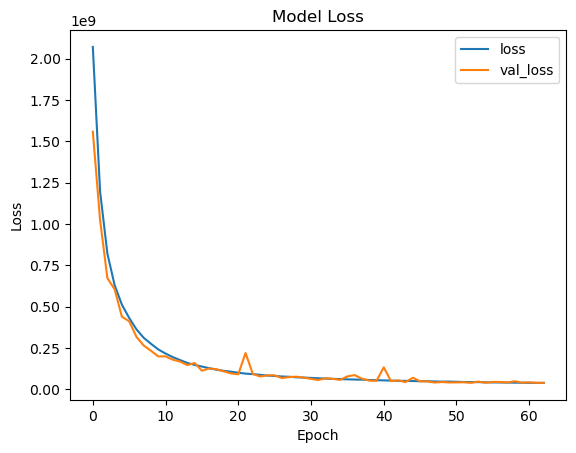

In [57]:
import matplotlib.pyplot as plt
# Loss 그래프 그리기
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# 검증 데이터 예측 및 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE on test data: {mse}")

9561/9561 [==============================] - 23s 2ms/step
MSE on test data: 40526038.430235356


In [59]:
# 예측 결과를 원래의 타겟 변수 스케일로 변환
# 테스트 데이터 스케일링 후 예측
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Original RMSE on test data: {np.sqrt(mse)}")
print(f"Original MAE on test data: {mae}")

Original RMSE on test data: 6366.006474253333
Original MAE on test data: 4215.858472660566


In [60]:
from sklearn.metrics import r2_score

r2_score = r2_score(y_test, y_pred)
print(f"R2 Score on test data: {r2_score}")

R2 Score on test data: 0.9870697624682893


In [61]:
model.save("./trained/05/model/")

INFO:tensorflow:Assets written to: ./trained/05/model/assets


In [62]:
import joblib

filename = './trained/05/preprocessor/prediction_x_preprocessor.joblib'
joblib.dump(prediction_x_preprocessor, filename)


filename = './trained/05/preprocessor/x_scaled_pipeline.joblib'
joblib.dump(x_scaled_pipeline, filename)

filename = './trained/05/preprocessor/train_x_y_pipeline.joblib'
joblib.dump(train_x_y_pipeline, filename)

['./trained/05/preprocessor/train_x_y_pipeline.joblib']